<a href="https://colab.research.google.com/github/otoperalias/miscellanea/blob/main/TrackingBabyWeight_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolución del peso de los bebés

* Este notebook está diseñado para el caso de mellizos/gemelos, para casos de un solo bebé, ver [aquí](https://github.com/otoperalias/miscellanea/blob/main/TrackingBabyWeight.ipynb).
* El notebook permite crear una base de datos añadiendo el peso de los bebés, que los guarda en una hoja de Google Sheets, y representarlos gráficamente junto a los percentiles de crecimiento estándars de la OMS.
* Consultar [este notebook](https://github.com/otoperalias/miscellanea/blob/main/TrackingBabyWeight.ipynb) para las instrucciones de uso. Dicho notebook está mejor preparado para uso general que el presente, el cual contiene los valores personales de mis hijos. No obstante, es fácil adaptarlo para uso propio.

### Código

¿Quieres actualizar la tabla? S/N: N


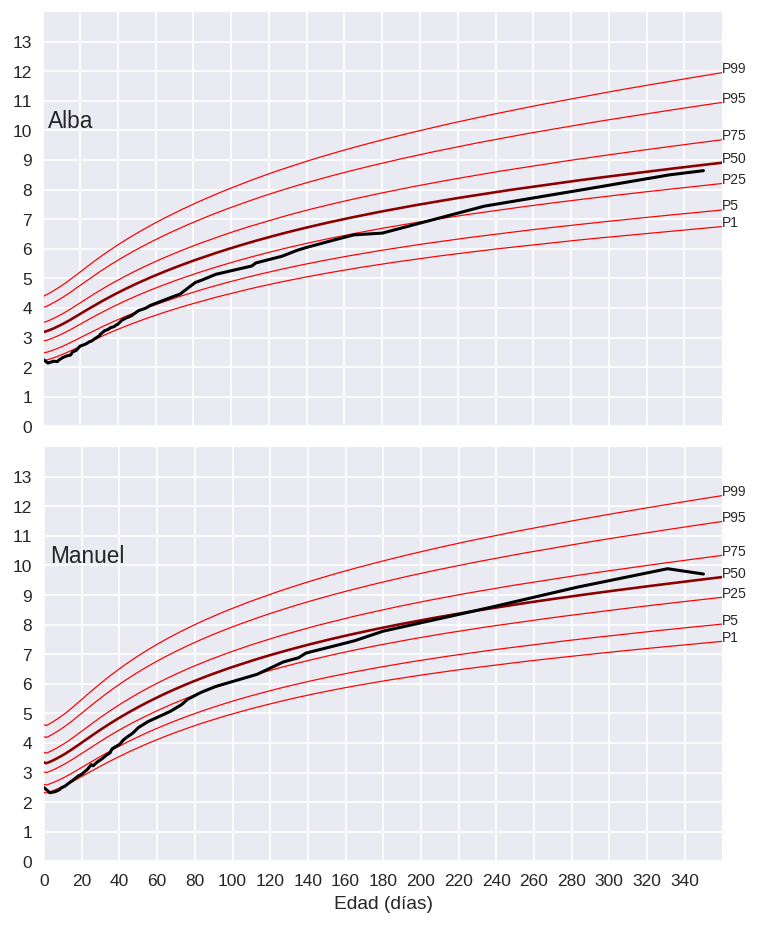

In [43]:
# Imports (general)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
hoy=pd.to_datetime("today").strftime('%Y-%m-%d')

# Get permission to google drive
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Datos de peso de Alba y Manuel
worksheet = gc.open("Registro_peso_AM").sheet1  # Registro_peso_AM= nombre dado a la hoja de Google Sheets
# Convert to a DataFrame
rows = worksheet.get_all_values()
df=pd.DataFrame.from_records(rows)
df.drop([0],inplace=True)
df.rename(columns={0:"fecha",1:"edad",2:"Alba",3:"Manuel"},inplace=True)
df=df.set_index("fecha")
df.index = pd.to_datetime(df.index)

# Update dataframe and save
update=input("¿Quieres actualizar la tabla? S/N: ")  # 1. Decimos si quieremos actualizar la tabla
if update=="S":
  while update=="S":
    nombre=input("Alba o Manuel: ")  # 2. Indicamos el nombre del bebé
    assert nombre=="Alba" or nombre=="Manuel", "Error en el nombre!"
    fecha_hoy=input("¿Fecha de hoy?: S/N ")  # 3. Indicamos si es la fecha de hoy
    if fecha_hoy=="S":
      fecha=hoy  # Si la fecha es la de hoy, la rellena automáticamente.
    else:
      fecha=input("Fecha: XXXX-XX-XX (Año/Mes/Día): ")
    peso=input("Peso (decimales con punto): ")
    df.loc[fecha,nombre]=peso
    update=input("¿Quieres actualizar MÁS la tabla? S/N: ")
  # Actualizar
  import gspread_dataframe as gd
  gd.set_with_dataframe(worksheet, df.reset_index())

# Procesamos datos
df[["a","m"]]=df[["Alba","Manuel"]]
df["a"]=pd.to_numeric(df["a"],errors='coerce')
df["m"]=pd.to_numeric(df["m"],errors='coerce')
df["edad"]=pd.to_numeric(df["edad"],errors='coerce')
# Restar peso de pañal y body (excepto primeras dos medidas en el hospital)
df.loc["2021-11-27":,["a","m"]]=df.loc["2021-11-27":,["a","m"]]-0.06
# Interpolación lineal
  # Alba
df_nona_a = df.dropna(subset = ['a'])
f = interp1d(df_nona_a['edad'], df_nona_a['a'])
fechamax_a=df["a"].last_valid_index()
df.loc[:fechamax_a,"a"] = f(df.loc[:fechamax_a,'edad'])
  # Manuel
df_nona_m = df.dropna(subset = ['m'])
f = interp1d(df_nona_m['edad'], df_nona_m['m'])
fechamax_m=df["m"].last_valid_index()
df.loc[:fechamax_m,"m"] = f(df.loc[:fechamax_m,'edad'])
  # Set Age as index
df=df.set_index("edad")

# Growth standards
girls=pd.read_csv("https://raw.githubusercontent.com/otoperalias/miscellanea/main/data/wfa_girls_p_exp.csv",sep=";", index_col=0)
boys=pd.read_csv("https://raw.githubusercontent.com/otoperalias/miscellanea/main/data/wfa_boys_p_exp.csv",sep=";", index_col=0)

  # GRÁFICO
plt.style.use('seaborn')
fig,(ax1,ax2)=plt.subplots(2,figsize=(7,9),sharex=True, dpi=125)
# Alba
girls[["P1","P5","P25","P50","P75","P95","P99"]].plot(ax=ax1, color="red",lw=0.7)
girls["P50"].plot(ax=ax1, color="darkred",lw=1.5)
df["a"].plot(ax=ax1,color="black")
ax1.get_legend().remove()
ax1.set_xlim(1,360)
ax1.set_ylim(1,14) 
ax1.text(3,10.1,"Alba",size=13)
ax1.set_yticks(np.arange(0, 14, 1))
for p in ["P1","P5","P25","P50","P75","P95","P99"]:
  ax1.text(360,girls[p].iloc[360],p,size=8)
# Manuel
boys[["P1","P5","P25","P50","P75","P95","P99"]].plot(ax=ax2, color="red",lw=0.7)
boys["P50"].plot(ax=ax2, color="darkred",lw=1.5)
df["m"].plot(ax=ax2,color="black")
ax2.get_legend().remove()
ax2.set_xlim(1,360)
ax2.set_ylim(1,14)
ax2.text(3,10.1,"Manuel",size=13)
ax2.set_xlabel("Edad (días)")
ax2.set_xticks(np.arange(0, 360, 20))
ax2.set_xticklabels([x for x in np.arange(0, 370, 20)])
ax2.set_yticks(np.arange(0, 14, 1))
for p in ["P1","P5","P25","P50","P75","P95","P99"]:
  ax2.text(360,boys[p].iloc[360],p,size=8)
plt.subplots_adjust(hspace=0.05)
plt.show()